In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
import glob
import os
import peakutils
import datetime
import warnings
import logging
from jupyterthemes import jtplot

In [118]:
from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_bg import *

jtplot.style('default', grid=False)
logging.getLogger().setLevel(logging.CRITICAL)

plt.rcParams['errorbar.capsize'] = 8
plt.rcParams['font.size'] = 18
plt.rc('font', size= 18)
plt.rc('legend', fontsize= 15)
plt.rc('xtick', labelsize= 18)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', size=6)

plt.rc('ytick', labelsize= 18)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)

In [3]:
asf = dict({'C1s' : 0.296, 'O1s' : 0.711, 'N1s' : 0.477, 'Br3p' : 1.054, 'Br3d' : 1.054,
           'In3d' : 4.359, 'Sn3d' : 4.725, 'Cl2p' : 0.891, 'Si2p': 0.339})

In [4]:
def plot_xp_regions(experiments : list, regions : list, ncols: int = 3):
    """Subplots all regions of a list of experiments (unnormalised)"""
    rows = int(np.ceil(len(regions) / ncols))

    fig, ax = plt.subplots(rows, ncols, figsize=(16, 8))
    for i,r in enumerate(regions):
            for c,xp in enumerate(experiments):
                j, k = i//ncols, i%ncols
                if i == len(regions) - 1:   # Set labels from last region
                    lb = xp.name
                else:
                    lb='__nolabel__'
                
                try:
                    li = plot_region(xp, r, ax=ax[j][k], lb=lb)
                except KeyError:
                    pass
                
                ax[j][k].set_title(r)
                leg = ax[j][k].get_legend()
                if leg is not None: leg.remove()
                cosmetics_plot(ax=ax[j][k], leg = False);
                
            if len(experiments)%2 == 0:
                ax[j][k].invert_xaxis()
    fig.legend(loc='upper right', bbox_to_anchor=(1.12, 0.5), fontsize=16)
    plt.tight_layout()

## Pre-processing of data annealed APTES on ITO O3, plasma
1- Sample ZF594_PA1

# APTES data, ZF594_PA1

## Import raw data

In [119]:
path = '/Users/pabloherrero/sabat/xps_spectra/ITO_DEA/ITO_APTES_anneal/*.xy'
files = glob.glob(path, recursive=True)
files.sort()
files_new = ['/Users/pabloherrero/sabat/xps_spectra/ITO_ox/6_ITO_sputter_anneal_plasma_10h/20200123_ITO_sputter_anneal_plasma_10h.xy']

for f in files:
    files_new.append(f)

files = files_new
for f in files:
    print(os.path.split(f)[1])

20200123_ITO_sputter_anneal_plasma_10h.xy
20201202_ITO_DEA_ZTF594_PA1_rep.xy
20201203_ITO_DEA_ZTF594_PA1_Annealing.xy
20201207_ITO_DEA_ZTF594_PA15_Annealing.xy


In [120]:
experiments = import_group_xp(files[2])   # The function returns a list

In [121]:
experiments.append(xps_data_import(files[0]))

In [127]:
experiments[0].name

'R'

### Import previous experiments (excluded)

In [19]:
experiments = [xps_data_import(path=f) for f in files[:-1]]
experiments[1].name

'ITO_DEA_ZTF594_PA1_rep'

In [122]:
for xp in experiments:
    xp.name = xp.name.strip('ITO_DEA_')    
    try:
        xp.dfx.rename_axis({'In3d5/2': 'In3d'}, axis=1, copy=False, inplace=True)
        xp.dfx.rename_axis({'Sn3d5/2': 'Sn3d'}, axis=1, copy=False, inplace=True)
        xp.dfx.rename_axis({'Br3p3/2': 'Br3p'}, axis=1, copy=False, inplace=True)
#         xp.dfx.rename_axis({'Br3p_(2)': 'Br3p'}, axis=1, copy=False, inplace=True)
    except KeyError:
        pass

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  after removing the cwd from sys.path.
/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  """
/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  


## Align from In 3d

/Users/pabloherrero/sabat/sabatsw/xps/xps_analysis.py:64: RuntimeWarning: invalid value encountered in greater
  dropup = np.where(xp.dfx[region].energy.values > eup)[0]


Text(0.5, 1.0, 'In 3d')

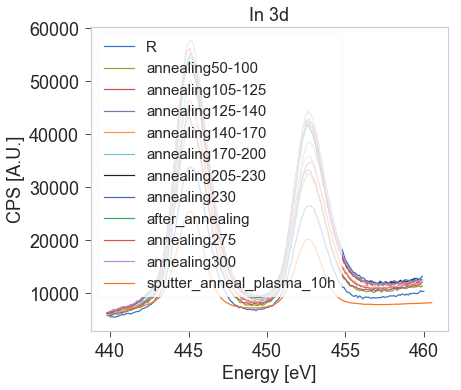

In [123]:
region = 'In3d'
aligned_exps = []

for xp in experiments:
    xp_new = crop_spectrum(xp, region=region, eup=None, edw=440)
    
    shift = find_shift(xp_new, xpRef=experiments[0], region=region)
    align_dfx(xp_new, shift, inplace = True)
    aligned_exps.append(xp_new)
    plot_region(xp_new, region)
plt.title('In 3d')

## Bg subtraction

### In 3d

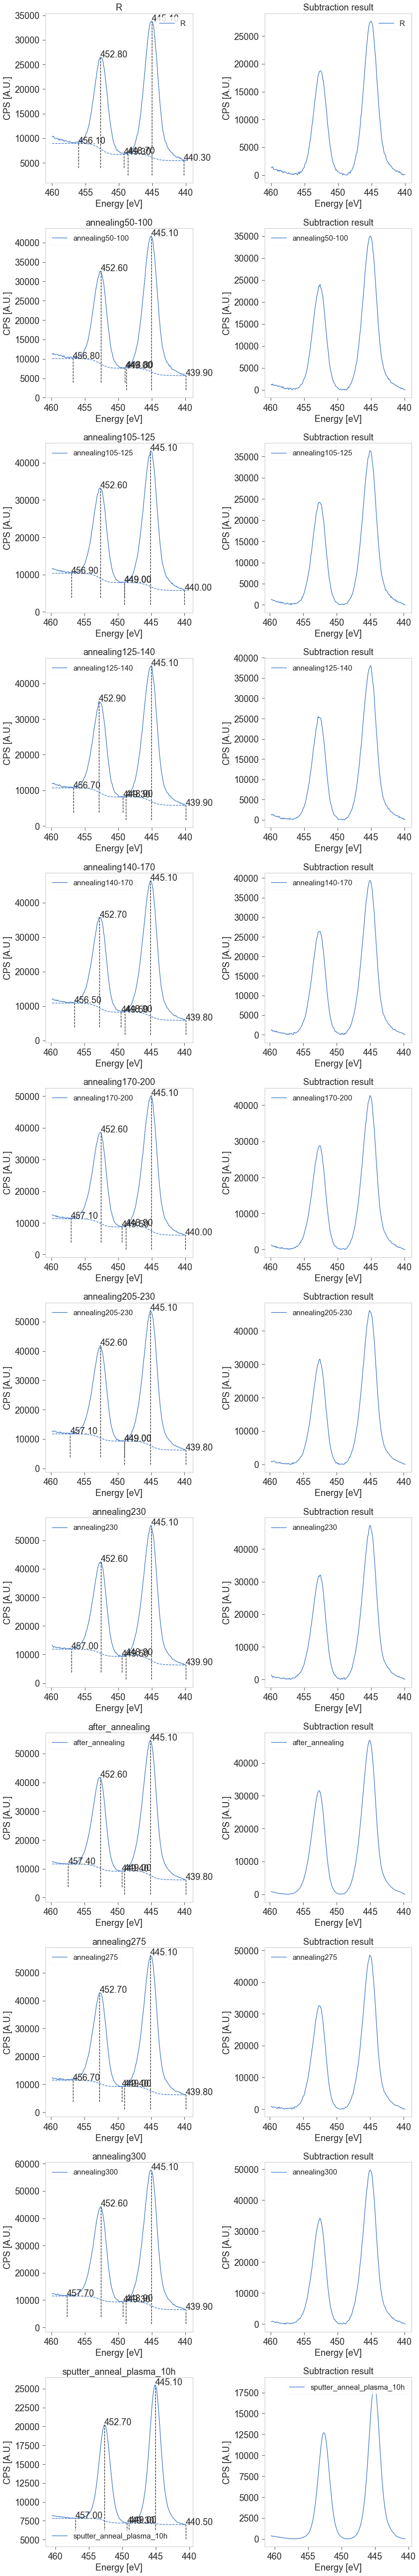

In [124]:
region = 'In3d'
bg_exps = region_2bg_subtract(aligned_exps, region, xlim=449)

### Sn 3d

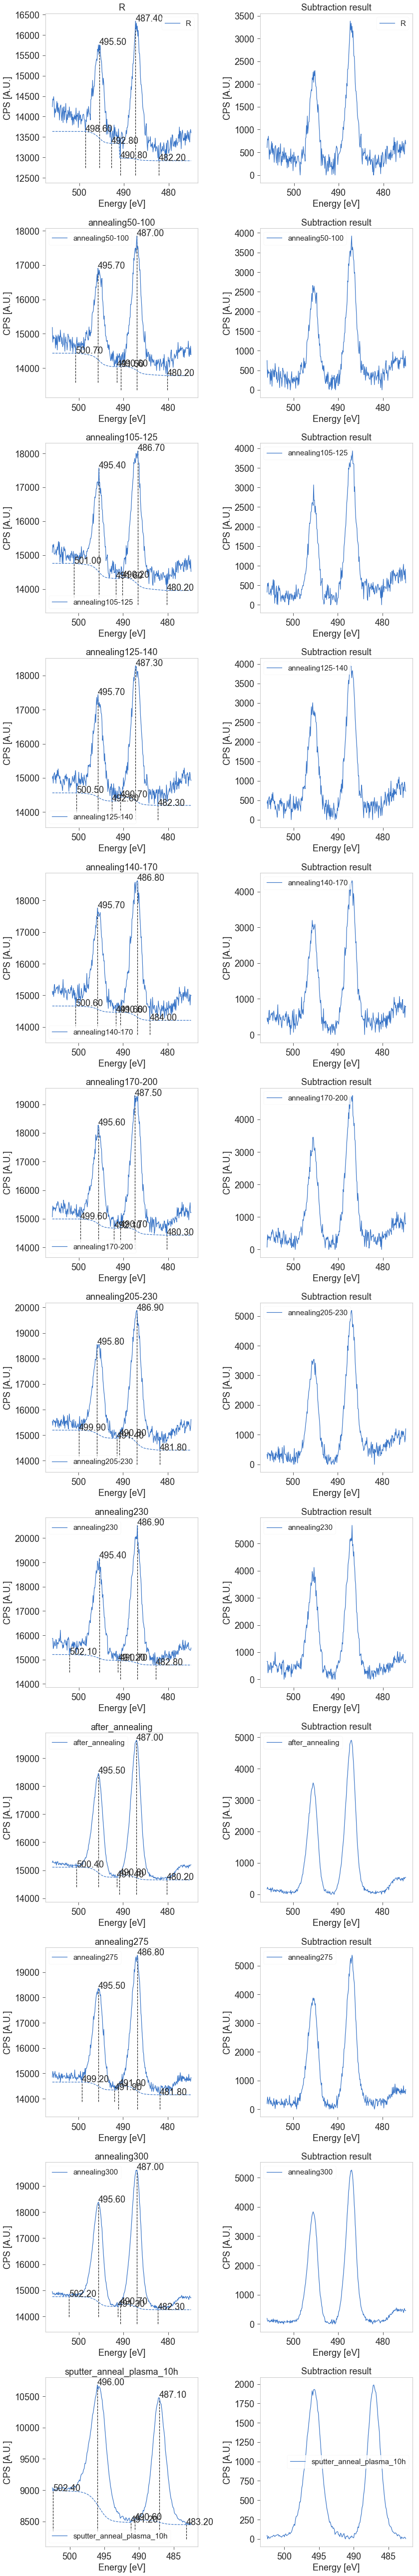

In [125]:
region = 'Sn3d'
bg_exps = region_2bg_subtract(bg_exps, region, xlim=491)

### C, N, O and Br

Max iterations exceeded, subtract ALS baseline
KeyError on  'Br3p'


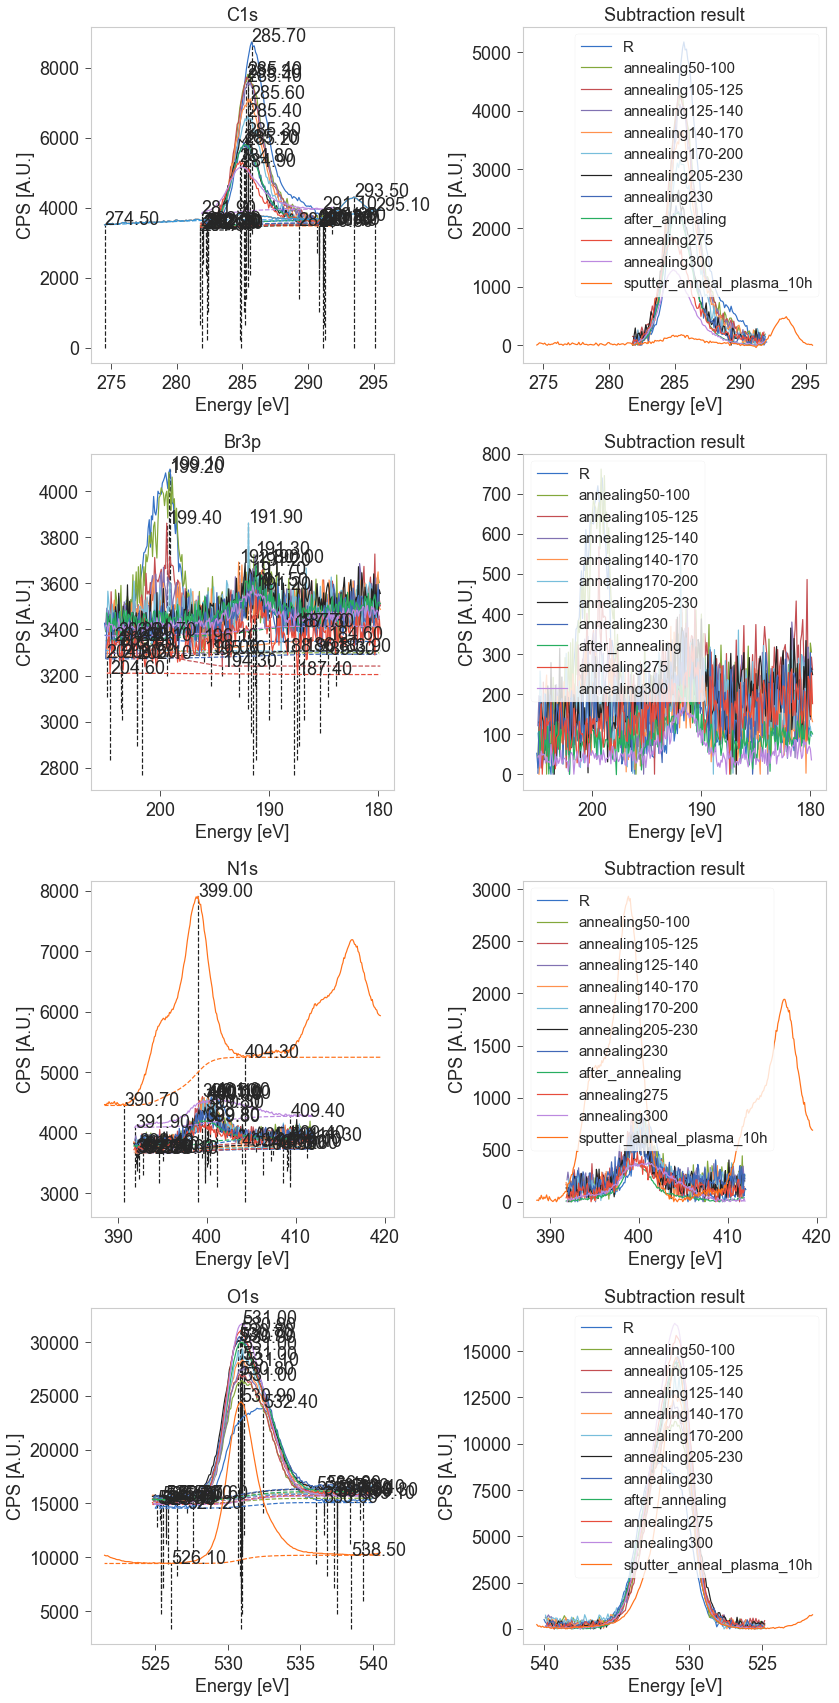

In [132]:
regions = ['C1s', 'Br3p', 'N1s', 'O1s']
bg_exps = bulk_bg_subtract(bg_exps, regions)

### Si 2p

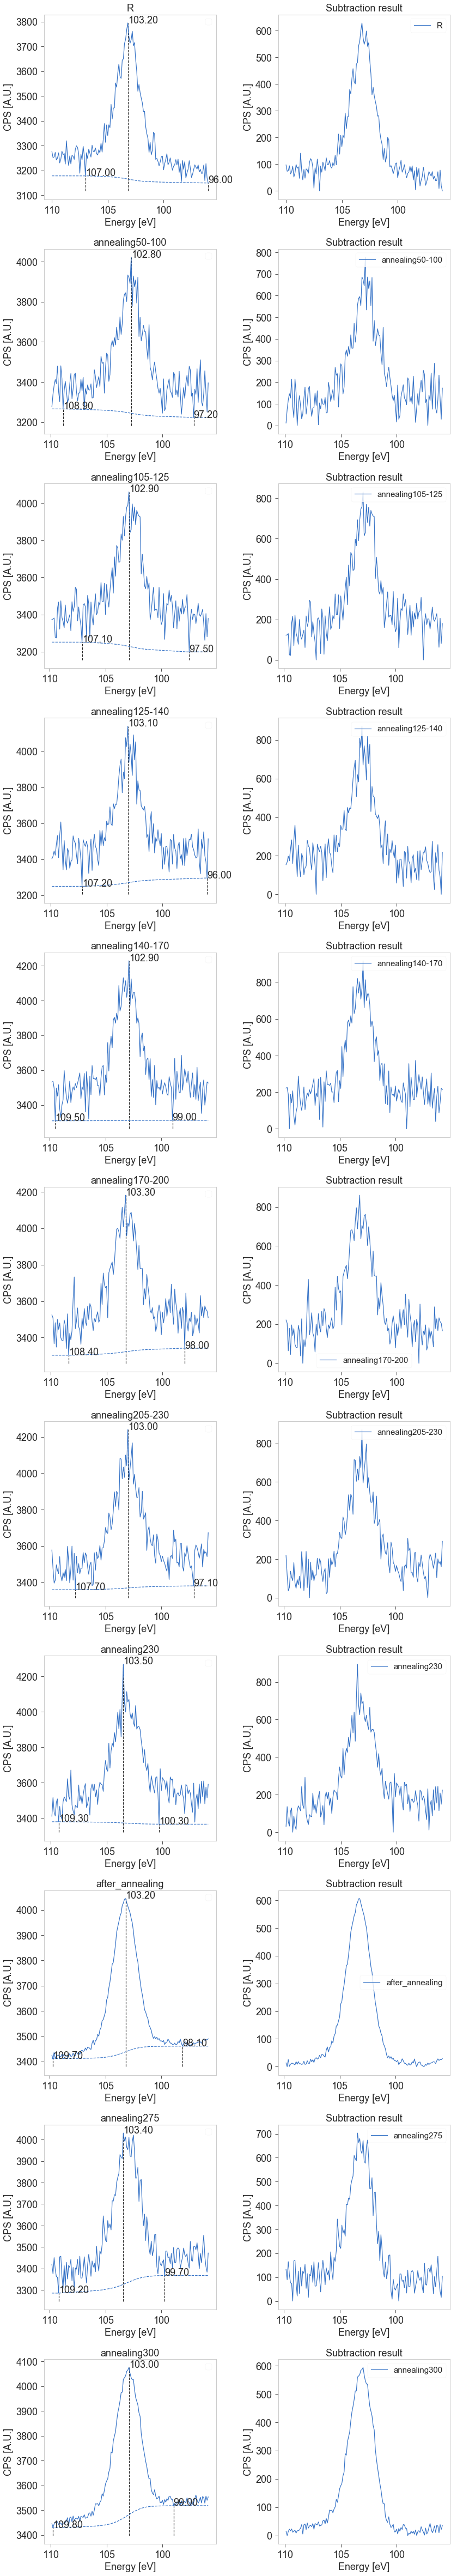

In [134]:
region = 'Si2p'
bg_exps[:-1] = region_bg_subtract(bg_exps[:-1], region)

## Plot spectra 

In [135]:
bg_exps[7].color = 'brown'
bg_exps[5].color = 'lime'

In [38]:
regions = experiments[0].dfx.columns.levels[0].values
regions

array(['Br3p', 'C1s', 'In3d', 'N1s', 'O1s', 'Si2p', 'Sn3d'], dtype=object)

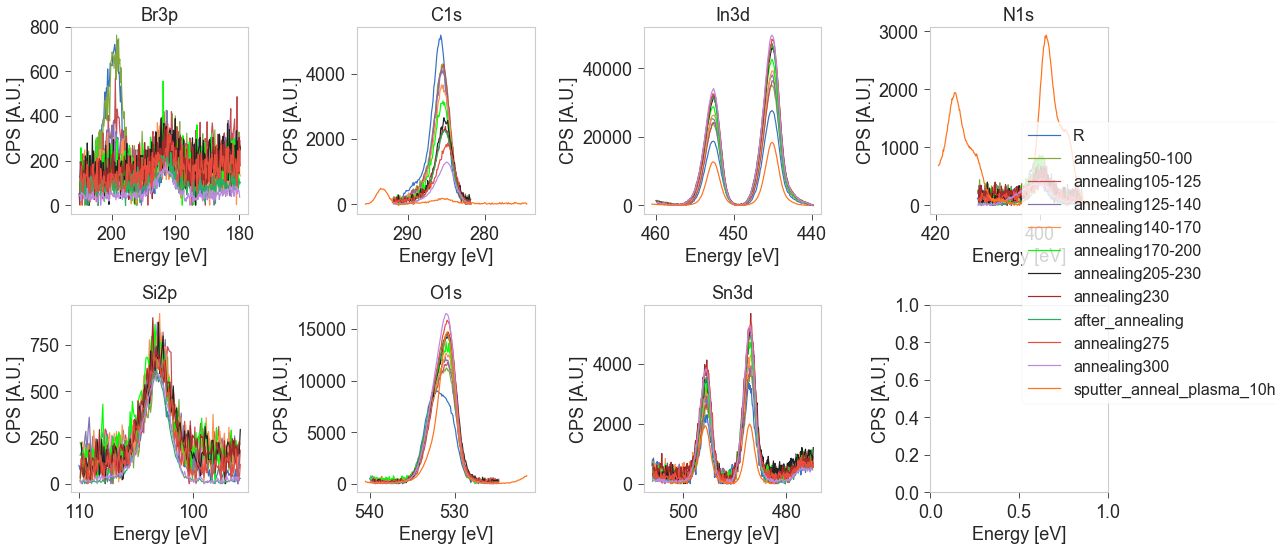

In [136]:
regions = ['Br3p', 'C1s', 'In3d', 'N1s', 'Si2p', 'O1s', 'Sn3d']
plot_xp_regions(bg_exps, regions, ncols=4)

## Scale Plasma experiment (considered clean ref.) to annealing 300 ºC (cleanest in group)

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


XPS_experiment(path='/Users/pabloherrero/sabat/xps_spectra/ITO_ox/6_ITO_sputter_anneal_plasma_10h/20200123_ITO_sputter_anneal_plasma_10h.xy', delimiters=([42, 1275, 1494, 1733, 2072, 2301], [1205, 191, 211, 311, 201, 271], ['overview_', 'O1s', 'C1s', 'N1s', 'Sn3d5/2', 'In3d5/2']), name='sputter_anneal_plasma_10h', label='20200123_ITO_sputter_anneal_plasma_10h', date='2020.01.23', other_meta='ITO_sputter_anneal_plasma_10h', dfx=        C1s                In3d                 N1s                 O1s  \
     energy       counts energy       counts energy       counts energy   
0     295.5    -6.020845  460.5  1040.015678  419.5  1856.692579  540.5   
1     295.4    35.604605  460.4   891.673587  419.4  1871.920223  540.4   
2     295.3    20.747971  460.3   889.359201  419.3  1912.743268  540.3   
3     295.2    45.311573  460.2   883.111007  419.2  1962.638101  540.2   
4     295.1    35.965664  460.1   836.672093  419.1  2108.758684  540.1   
5     295.0    61.937119  460.0   820.549421

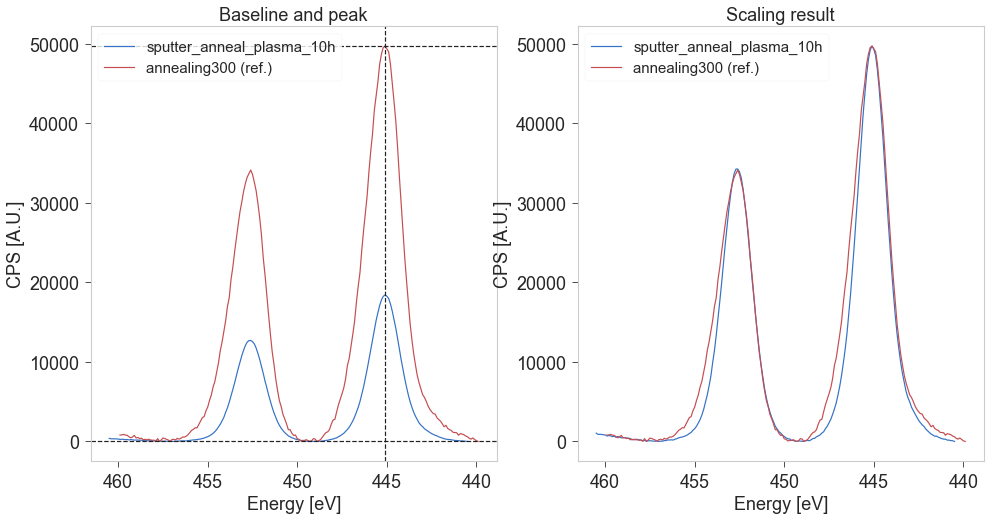

In [138]:
factor = scale_and_plot_spectra(bg_exps[-1], bg_exps[-2], region='In3d', )
scale_dfx(bg_exps[-1], scale_factor=factor, inplace=True)

## Store processed experiments

In [141]:
bg_exps[0].name = 'RT'

In [142]:
import os
for xp in bg_exps:
    filepath, filename = os.path.split(xp.path)
    newpath = filepath + '/proc/'
    try:
        os.mkdir(newpath)
    except FileExistsError: pass
    print(filename.replace('Annealing', xp.name))
#     print(newpath + filename + xp.name)

    write_processed_xp(newpath + filename.replace('Annealing', xp.name), xp)

20201203_ITO_DEA_ZTF594_PA1_RT.xy
20201203_ITO_DEA_ZTF594_PA1_annealing50-100.xy
20201203_ITO_DEA_ZTF594_PA1_annealing105-125.xy
20201203_ITO_DEA_ZTF594_PA1_annealing125-140.xy
20201203_ITO_DEA_ZTF594_PA1_annealing140-170.xy
20201203_ITO_DEA_ZTF594_PA1_annealing170-200.xy
20201203_ITO_DEA_ZTF594_PA1_annealing205-230.xy
20201203_ITO_DEA_ZTF594_PA1_annealing230.xy
20201203_ITO_DEA_ZTF594_PA1_after_annealing.xy
20201203_ITO_DEA_ZTF594_PA1_annealing275.xy
20201203_ITO_DEA_ZTF594_PA1_annealing300.xy
20200123_ITO_sputter_anneal_plasma_10h.xy


## Export to csv

In [57]:
filepath
try:
    os.mkdir(filepath + '/itx/')
except FileExistsError: pass

In [61]:
xp = bg_exps[0]
regions = xp.dfx.columns.levels[0].values
regions

array(['Br3p', 'C1s', 'In3d', 'N1s', 'O1s', 'Si2p', 'Sn3d'], dtype=object)

In [64]:
import csv

In [73]:
xp.dfx['Br3p'].counts.dropna().shape

(252,)

In [79]:
fileitx = filepath + '/itx/' + filename.replace('Annealing', bg_exps[0].name).replace('.xy', '.itx')
xp = bg_exps[0]
with open(fileitx, 'w') as fout:
    writer = csv.writer(fout, delimiter=' ')
    regions = xp.dfx.columns.levels[0].values
    writer.writerow(['IGOR'])
    for i,r in enumerate(regions, start=1):
        regstr = str(i)+'_'+r
        writer.writerow(['WAVES/S/N=(%i)'%len(xp.dfx[r].counts.dropna()), "'%s'" %regstr])
        writer.writerow(['BEGIN'])
        writer.writerow(xp.dfx[r].counts.dropna().values)
        writer.writerow(['END'])
        writer.writerow(['X SetScale/I x,', xp.dfx[r].energy.min(), xp.dfx[r].energy.max(), 
                        "Binding Energy [eV]", regstr])
        writer.writerow(['X SetScale/I d,', xp.dfx[r].counts.min(), xp.dfx[r].counts.max(), 
                        'cps (Intensity)', regstr])
        
        
    
#     writer.writerow(['dfx', ''])


In [93]:
header = ''.join('%s_BE;%s_cps;' %(r, r) for r in regions)
header

'Br3p_BE;Br3p_cps;C1s_BE;C1s_cps;In3d_BE;In3d_cps;N1s_BE;N1s_cps;O1s_BE;O1s_cps;Si2p_BE;Si2p_cps;Sn3d_BE;Sn3d_cps;'

In [143]:
file = filepath + '/itx/' + filename.replace('Annealing', bg_exps[0].name).replace('.xy', '.csv')
def export_csv(file: str, xp: XPS_experiment):
    """Export to Igor compatible csv format"""
    with open(file, 'w') as fout:
        regions = xp.dfx.columns.levels[0].values
        header = ''.join('%s_BE\t%s_cps\t' %(r, r) for r in regions)
        fout.write(header+'\n')
        xp.dfx.to_csv(fout, sep='\t', na_rep='NaN', index=None, header=False)

In [112]:
export_csv(file, xp)

In [148]:
bg_exps[0].path

'/Users/pabloherrero/sabat/xps_spectra/ITO_DEA/ITO_APTES_anneal/20201203_ITO_DEA_ZTF594_PA1_Annealing.xy'

In [150]:
for xp in bg_exps:
    filepath, filename = os.path.split(xp.path)
    file = filepath + '/itx/' + filename.replace('Annealing', xp.name).replace('.xy', '.csv')
    try:
        os.mkdir(filepath + '/itx/')
    except FileExistsError: pass
    export_csv(file, xp)

# Second set: APTES PA15 

In [119]:
path = '/Users/pabloherrero/sabat/xps_spectra/ITO_DEA/ITO_APTES_anneal/*.xy'
files = glob.glob(path, recursive=True)
files.sort()
files_new = ['/Users/pabloherrero/sabat/xps_spectra/ITO_ox/6_ITO_sputter_anneal_plasma_10h/20200123_ITO_sputter_anneal_plasma_10h.xy']

for f in files:
    files_new.append(f)

files = files_new
for f in files:
    print(os.path.split(f)[1])

20200123_ITO_sputter_anneal_plasma_10h.xy
20201202_ITO_DEA_ZTF594_PA1_rep.xy
20201203_ITO_DEA_ZTF594_PA1_Annealing.xy
20201207_ITO_DEA_ZTF594_PA15_Annealing.xy


In [176]:
experiments = import_group_xp(files[3])   # The function returns a list

## Align from In 3d

/Users/pabloherrero/sabat/sabatsw/xps/xps_analysis.py:64: RuntimeWarning: invalid value encountered in greater
  dropup = np.where(xp.dfx[region].energy.values > eup)[0]


Text(0.5, 1.0, 'In 3d')

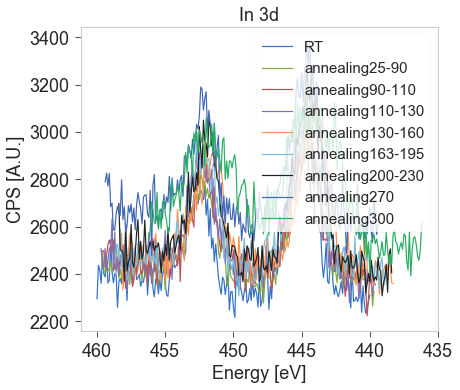

In [184]:
region = 'In3d'
aligned_exps = []

for xp in experiments:
    xp_new = crop_spectrum(xp, region=region, eup=None, edw=440)
    
    shift = find_shift(xp_new, xpRef=experiments[0], region=region)
    align_dfx(xp_new, shift, inplace = True)
    aligned_exps.append(xp_new)
    plot_region(xp_new, region)
plt.title('In 3d')

## Bg subtraction

### In 3d

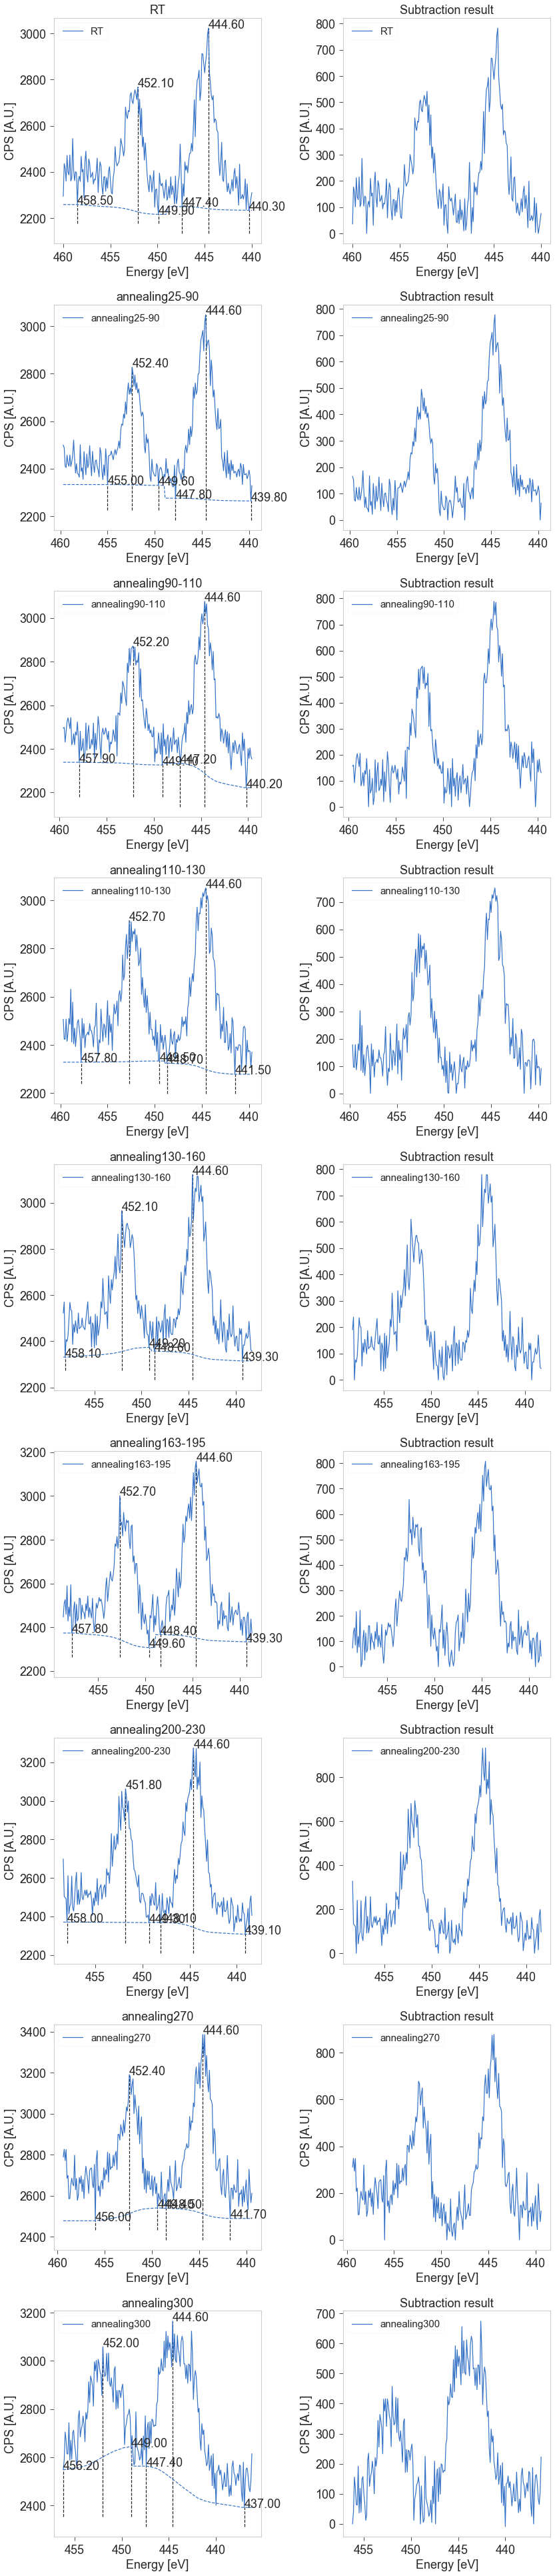

In [190]:
region = 'In3d'
bg_exps = region_2bg_subtract(aligned_exps, region, xlim=449)

### Sn 3d

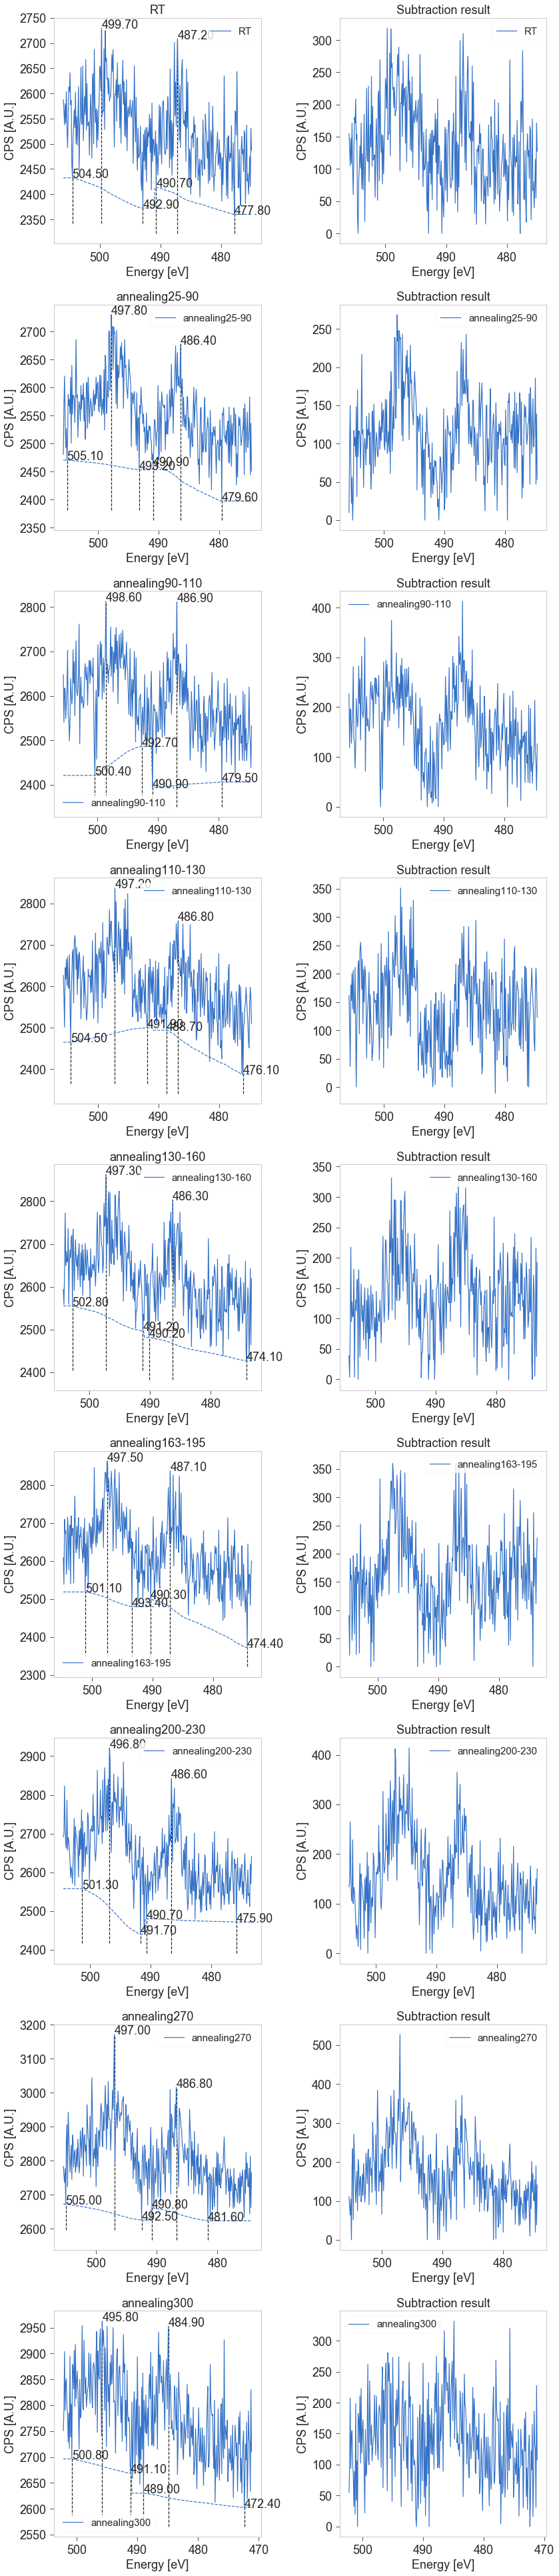

In [191]:
region = 'Sn3d'
bg_exps = region_2bg_subtract(bg_exps, region, xlim=491)

### C, N, O and Br

Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline


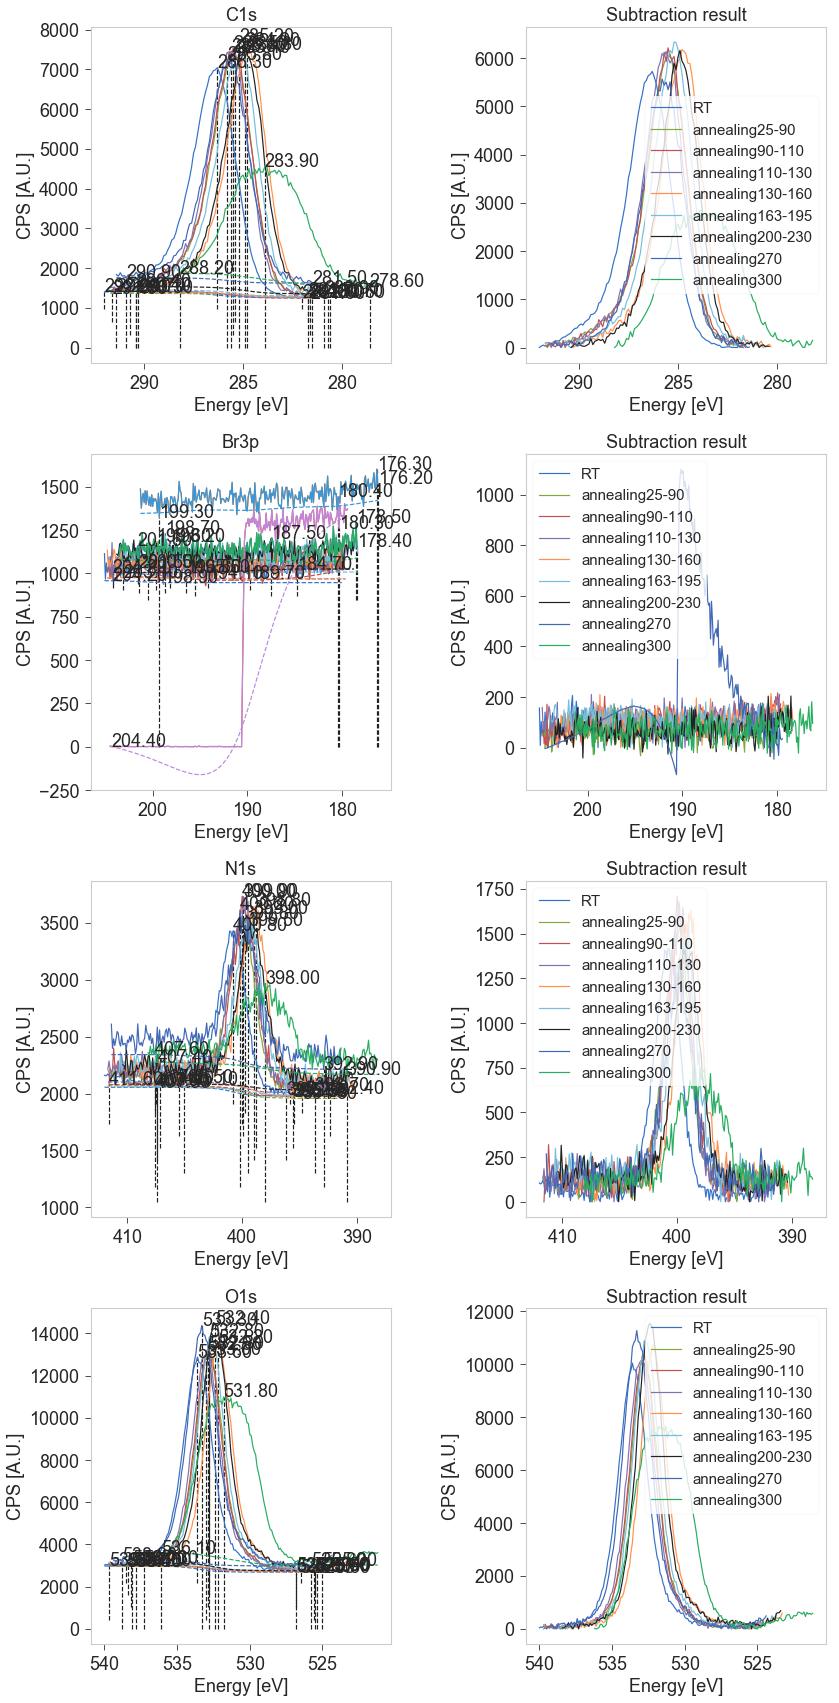

In [192]:
regions = ['C1s', 'Br3p', 'N1s', 'O1s']
bg_exps = bulk_bg_subtract(bg_exps, regions)

### Si 2p

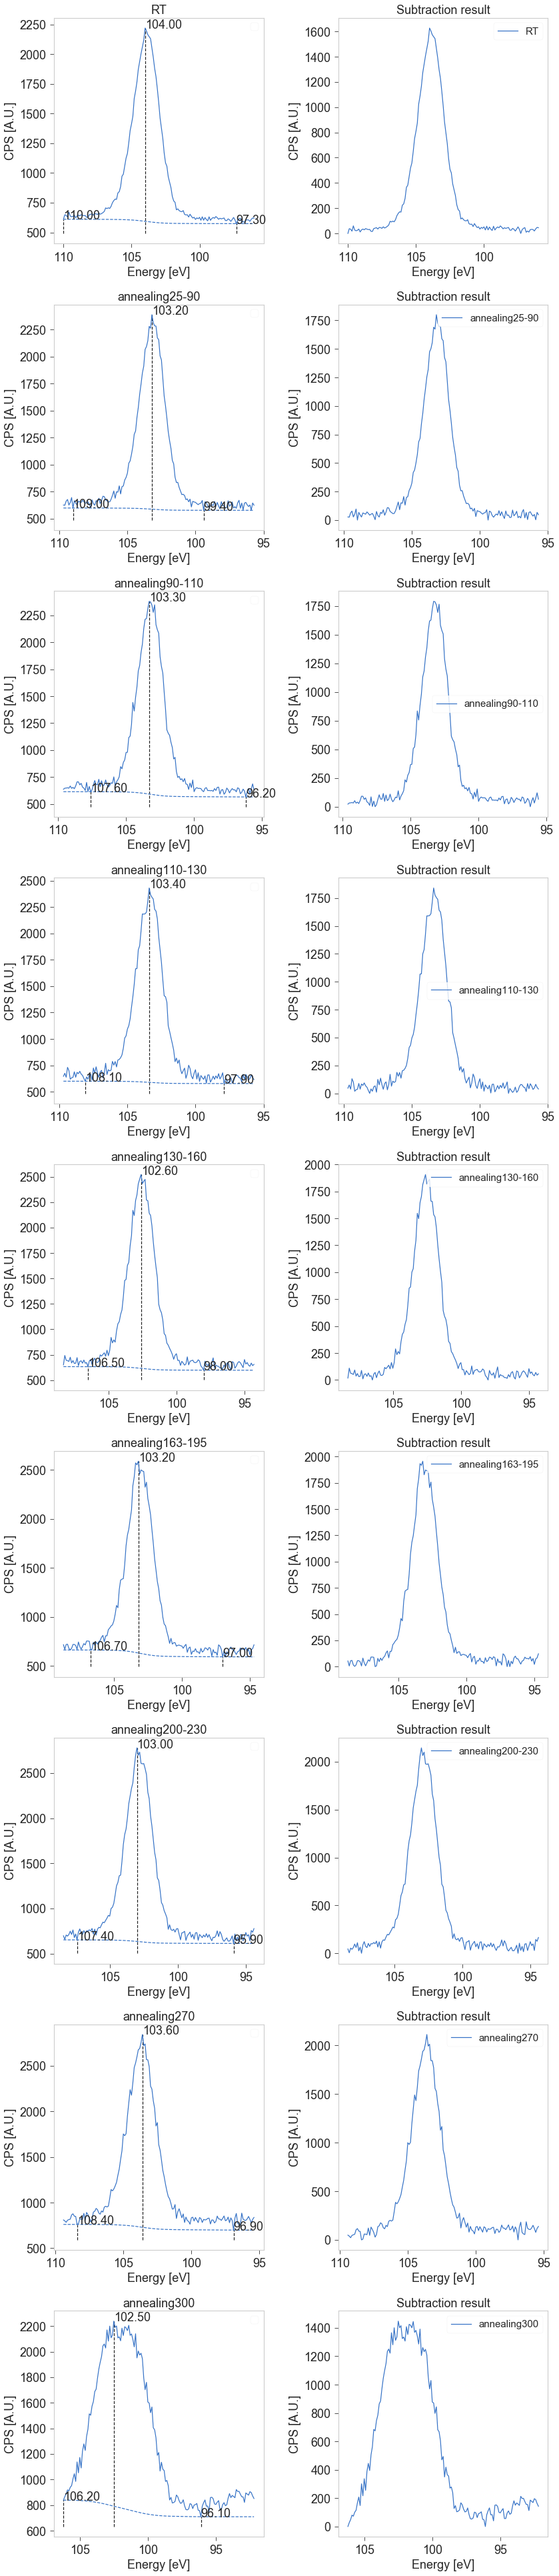

In [193]:
region = 'Si2p'
bg_exps = region_bg_subtract(bg_exps, region)

## Plot spectra 

In [194]:
bg_exps[7].color = 'brown'
bg_exps[5].color = 'lime'

In [195]:
regions = experiments[0].dfx.columns.levels[0].values
regions

array(['Br3p', 'C1s', 'In3d', 'N1s', 'O1s', 'Si2p', 'Sn3d'], dtype=object)

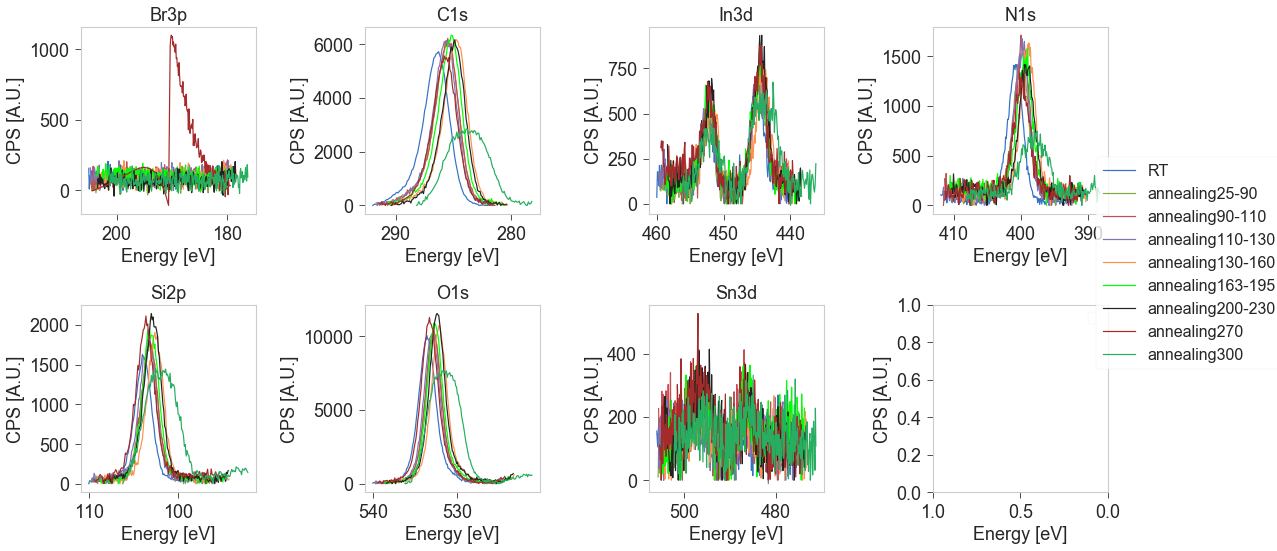

In [196]:
regions = ['Br3p', 'C1s', 'In3d', 'N1s', 'Si2p', 'O1s', 'Sn3d']
plot_xp_regions(bg_exps, regions, ncols=4)

## Store processed experiments

In [197]:
bg_exps[0].name = 'RT'

In [198]:
import os
for xp in bg_exps:
    filepath, filename = os.path.split(xp.path)
    newpath = filepath + '/proc/'
    try:
        os.mkdir(newpath)
    except FileExistsError: pass
    print(filename.replace('Annealing', xp.name))
#     print(newpath + filename + xp.name)

    write_processed_xp(newpath + filename.replace('Annealing', xp.name), xp)

20201207_ITO_DEA_ZTF594_PA15_RT.xy
20201207_ITO_DEA_ZTF594_PA15_annealing25-90.xy
20201207_ITO_DEA_ZTF594_PA15_annealing90-110.xy
20201207_ITO_DEA_ZTF594_PA15_annealing110-130.xy
20201207_ITO_DEA_ZTF594_PA15_annealing130-160.xy
20201207_ITO_DEA_ZTF594_PA15_annealing163-195.xy
20201207_ITO_DEA_ZTF594_PA15_annealing200-230.xy
20201207_ITO_DEA_ZTF594_PA15_annealing270.xy
20201207_ITO_DEA_ZTF594_PA15_annealing300.xy


## Export to csv

In [199]:
for xp in bg_exps:
    filepath, filename = os.path.split(xp.path)
    file = filepath + '/csv/' + filename.replace('Annealing', xp.name).replace('.xy', '.csv')
    try:
        os.mkdir(filepath + '/csv/')
    except FileExistsError: pass
    export_csv(file, xp)

## Repeat with XPBackground class (Dev)

### Background subtraction class (dev) 

In [5]:
class Background2(object):
    @staticmethod
    def bg_handler(xp, region,  *args, **kwargs):
        x = xp.dfx[region].dropna().energy.values
        y = xp.dfx[region].dropna().counts.values
        return x, y

    @staticmethod
    def edit_xp(xp, region, x, y, ybg, ax = None):
        if ax == None: ax = plt.gca()
        col = plot_region(xp, region, lb=region, ax=ax).get_color()
        ax.plot(x, ybg, '--', color=col, label='__nolabel__')
        cosmetics_plot(ax=ax)
        
        dfnew = pd.DataFrame({'energy' : x, 'counts' : y - ybg})
        xpNew = deepcopy(xp)
        xpNew.dfx[region] = dfnew
        return xpNew

    def dec_linear(self, xp, region, *args, **kwargs):
        x, y = self.bg_handler(xp, region, *args, **kwargs)

        ybg = peakutils.baseline(y, deg=1)
        return self.edit_xp(xp, region, x, y, ybg)
    
    def dec_shirley(self, xp, region, maxit=40, **kwargs):
        kwargs['maxit'] = maxit
        x,y = self.bg_handler(xp, region, **kwargs)
        ybg = shirley_loop(x,y, **kwargs)
        return self.edit_xp(xp, region, x, y, ybg)
    
    def dec_2shirley(self, xp, region, xlim, maxit=40, **kwargs):
        x, y = self.bg_handler(xp, region, **kwargs)
        y1 = y[ x >= xlim ]
        x1 = x[ x >= xlim ]
        y2 = y[ x <= xlim ]
        x2 = x[ x <= xlim ]

        ybg1 = shirley_loop(x1, y1, maxit = maxit)#, flag_plot=flag_plot, ax = ax)
        ybg2 = shirley_loop(x2, y2, maxit = maxit)#, flag_plot=flag_plot, ax = ax)
        ybg = np.append(np.append(ybg1[:-1], np.average([ybg1[-1], ybg2[0]])), ybg2[1:] )
        return self.edit_xp(xp, region, x, y, ybg, **kwargs)

NameError: name 'trim_exps' is not defined

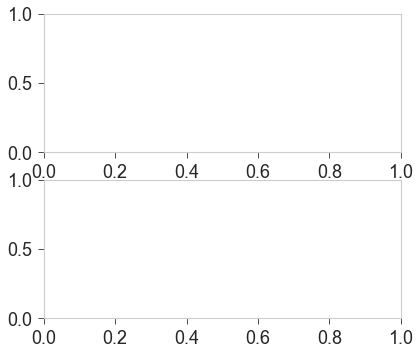

In [6]:
# Background2().dec_linear(xp=experiments[0], region='C_1s')
fig, ax = plt.subplots(2)
BG2 = Background2()
bg2 = BG2.dec_2shirley(xp=trim_exps[0], region='overview_', 
                       xlim = 346, maxit=50, ax=ax[0])
bg2 = BG2.dec_linear(xp=trim_exps[0], 
                     region='overview_', ax=ax[1])

In [ ]:
def test_bg_subpots()
    fig, ax = plt.subplots(2)
    BG2 = Background2()
    bg2 = BG2.dec_2shirley(xp=trim_exps[0], region='overview_', 
                           xlim = 346, maxit=50, ax=ax[0])
    bglin = BG2.dec_linear(xp=trim_exps[0], 
                         region='overview_', ax=ax[1])

    assert len(ax[0].get_lines()) <= 2, "Too many lines in lin_bg subplot"
    assert len(ax[0].get_lines()) >= 2, "Not enough lines in lin_bg subplot"

In [ ]:
BG2 = Background2()
bg2 = BG2.dec_2shirley(xp=trim_exps[0], region='overview_', 
                       xlim = 346, maxit=50, ax=ax[0])
x,y = BG2.bg_handler(xp=trim_exps[0], region='overview_')
x,ybg = BG2.bg_handler(bg2, region='overview_')
lentest = len(np.where(y < ybg)[0])
assert lentest == 0, "Background over signal in %i points"%lentest


In [ ]:
BG2 = Background2()
bg2 = BG2.dec_linear(xp=trim_exps[0], region='overview_')
x,y = BG2.bg_handler(xp=trim_exps[0], region='overview_')
x,ybg = BG2.bg_handler(bg2, region='overview_')
lentest = len(np.where(y < ybg)[0])
assert lentest == 0, "Background over signal in %i points"%lentest


In [ ]:
def test_method(method):
    BG2 = Background2()
    bg2 = method(xp=trim_exps[0], region='overview_')
    x,y = BG2.bg_handler(xp=trim_exps[0], region='overview_')
    x,ybg = BG2.bg_handler(bg2, region='overview_')
    lentest = len(np.where(y < ybg)[0])
    assert lentest == 0, "Background over signal in %i points"%lentest
test_method(Background2().dec_linear)

In [200]:
BG = XPBackground()

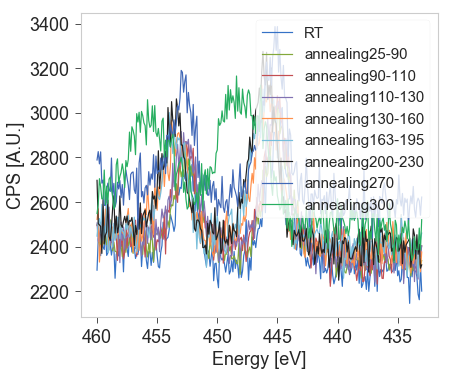

In [210]:
for xp in experiments:
    plot_region(xp, 'In3d')

shirley_loop: Max iterations exceeded before convergence.


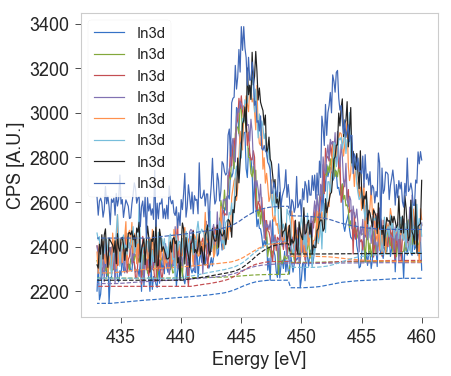

In [213]:
for xp in experiments:
    try:
        BG.doubleShirley(xp, 'In3d', xlim=449, maxit=100)
    except AssertionError as e:
        print(e)

In [216]:
totm = 227.37
9*12 / totm, 23 / totm, 14 /totm, 3*16 / totm, 28/ totm

(0.47499670141179573,
 0.10115670493028983,
 0.061573646479306854,
 0.2111096450719092,
 0.12314729295861371)

# Draft: ITO thickness from Si attenuation

$$ I_f = I_0 \exp{\left(-\frac{d_A \cos\theta}{\lambda_A} \right)}, $$

where $I_f$ and $I_0$ are the covered and clean intensities of the copper, $d_A$ is the coverage (thickness of layer A), $\theta$ is the takeoff angle and $\lambda_A$ is the mean free path of the material.

$\lambda_{ITO}$ = 0.56 nm

https://hal-cea.archives-ouvertes.fr/cea-01575439/document

$\cos\theta = \cos$(10º) = 0.9848


In [16]:
experiments[4].dfx

range        C_1s              N_1s             Cl_2p           O_1s  \
properties energy     counts energy     counts energy  counts energy   
0           295.0  1154.6667  405.0  1288.0000  215.0  1114.0  542.0   
1           294.9  1133.3333  404.9  1217.3333  214.9  1108.0  541.9   
2           294.8  1136.6667  404.8  1188.6667  214.8  1152.0  541.8   
3           294.7  1113.3333  404.7  1235.3333  214.7  1072.0  541.7   
4           294.6  1117.3333  404.6  1237.3333  214.6  1188.0  541.6   
5           294.5  1112.6667  404.5  1195.3333  214.5  1182.0  541.5   
6           294.4  1141.3333  404.4  1209.3333  214.4  1084.0  541.4   
7           294.3  1169.3333  404.3  1207.3333  214.3  1154.0  541.3   
8           294.2  1140.6667  404.2  1284.6667  214.2  1044.0  541.2   
9           294.1  1166.0000  404.1  1185.3333  214.1  1118.0  541.1   
10          294.0  1174.0000  404.0  1252.6667  214.0  1056.0  541.0   
11          293.9  1148.0000  403.9  1241.3333  213.9  1160.0  540.9   
12          293.8  1132.6667  403.8  1248.6667  213.8  1116.0  540.8   
13          293.7  1106.6667  403.7  1209.3333  213.7  1162.0  540.7   
14          293.6  1188.6667  403.6  1213.3333  213.6  1108.0  540.6   
15          293.5  1186.6667  403.5  1236.0000  213.5  1182.0  540.5   
16          293.4  1113.3333  403.4  1264.0000  213.4  1192.0  540.4   
17          293.3  1143.3333  403.3  1226.6667  213.3  1118.0  540.3   
18          293.2  1168.6667  403.2  1214.0000  213.2  1078.0  540.2   
19          293.1  1128.6667  403.1  1230.0000  213.1  1128.0  540.1   
20          293.0  1119.3333  403.0  1251.3333  213.0  1070.0  540.0   
21          292.9  1147.3333  402.9  1178.0000  212.9  1140.0  539.9   
22          292.8  1143.3333  402.8  1234.0000  212.8  1170.0  539.8   
23          292.7  1144.6667  402.7  1204.6667  212.7  1022.0  539.7   
24          292.6  1198.0000  402.6  1145.3333  212.6  1038.0  539.6   
25          292.5  1166.0000  402.5  1220.6667  212.5  1072.0  539.5   
26          292.4  1172.6667  402.4  1170.6667  212.4  1086.0  539.4   
27          292.3  1162.6667  402.3  1193.3333  212.3  1054.0  539.3   
28          292.2  1168.6667  402.2  1208.6667  212.2  1136.0  539.2   
29          292.1  1160.6667  402.1  1208.6667  212.1  1084.0  539.1   
..            ...        ...    ...        ...    ...     ...    ...   
471           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
472           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
473           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
474           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
475           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
476           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
477           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
478           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
479           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
480           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
481           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
482           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
483           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
484           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
485           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
486           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
487           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
488           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
489           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
490           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
491           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
492           NaN        NaN    NaN        NaN    NaN     NaN    NaN   
493           NaN        NaN    NaN     

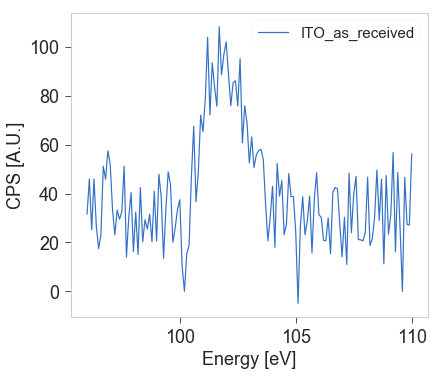

In [139]:
# xpf = crop_spectrum(bg_exps[0], region, eup=960, edw=925)
# xp0 = crop_spectrum(bg_exps[1], region, eup=960, edw=925)

plot_region(bg_exps[0], 'Si2p')
# plot_region(bg_exps[0], 'In3d')
cosmetics_plot()

In [141]:
If = np.trapz(bg_exps[0].dfx['Si2p'].dropna().counts, dx=0.1)/asf['Si2p']
I0 = np.trapz(bg_exps[0].dfx['In3d'].dropna().counts, dx=0.1)/asf['In3d']
from invisible_cities.core.system_of_units import nm
mfp = .56 * nm
costh = np.cos(10*np.pi/180)

thick = mfp/costh*np.log(I0/If)
thick / nm
# np.log(I0/If+1)

1.6298827933034263

######  Layer of 3.7 nm

## Taking the ratio of the maxima

In [29]:
If = np.max(xpf.dfx[region].dropna().counts)
I0 = np.max(xp0.dfx[region].dropna().counts)
from invisible_cities.core.system_of_units import nm
mfp = 3.85 * nm
costh = np.cos(10*np.pi/180)

thick = mfp/costh*np.log(I0/If)
thick / nm
# np.log(I0/If+1)

1.8414430142005438